# DS-GA 1011 Fall 2017 HW 01
# Bags of Words and Document Classification

In [1]:
import numpy as np
import os
import torch
from collections import Counter
from sklearn.feature_extraction import stop_words
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

In [2]:
# (some of the) hyper parameters
learning_rate = 0.001
vocab_size = 20000 # number words in the vocabulary base
emb_dim = 50 # dimension for n-gram embedding
num_epochs = 5 # number epoch to train
batch_size = 32
ngram_n = 2 # the n in n-gram

In [3]:
# I/O Param
data_dir = "./aclImdb/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
TRAIN_SIZE = 23000
VALIDATION_SIZE = 2000
TEST_SIZE = 25000
PADDING_IDX = 0

## Part I : Data I/O
Read data from disk and parse them into desired structures

In [4]:
class IMDBDatum():
    """
    Class that represents a train/validation/test datum
    - self.raw_text
    - self.label: 0 neg, 1 pos
    - self.file_name: dir for this datum
    - self.tokens: list of tokens
    - self.token_idx: index of each token in the text
    """
    def __init__(self, raw_text, label, file_name):
        self.raw_text = raw_text
        self.label = label
        self.file_name = file_name
        
    def set_ngram(self, ngram_ctr):
        self.ngram = ngram_ctr
    
    def set_token_idx(self, token_idx):
        self.token_idx = token_idx
        
    def set_tokens(self, tokens):
        self.tokens = tokens


def preprocess_text(text):
    """
    Function that cleans the string
    """
    text = text.lower().replace("<br />", "")
    return text
        
    
def read_file_as_datum(file_name, label):
    """
    Function that reads a file 
    """
    with open(file_name, "r") as f:
        content = f.read()
        content = preprocess_text(content)
    return IMDBDatum(raw_text=content, label=label, file_name=file_name)


def construct_dataset(dataset_dir, dataset_size, offset=0):
    """
    Function that loads a dataset
    @param offset: skip first offset items in this dir
    """
    pos_dir = os.path.join(dataset_dir, "pos")
    neg_dir = os.path.join(dataset_dir, "neg")
    single_label_size = int(dataset_size / 2)
    output = []
    all_pos = os.listdir(pos_dir)
    all_neg = os.listdir(neg_dir)
    for i in range(offset, offset+single_label_size):
        output.append(read_file_as_datum(os.path.join(pos_dir, all_pos[i]), 1))
        output.append(read_file_as_datum(os.path.join(neg_dir, all_neg[i]), 0))
    return output


In [5]:
# Load Dataset - should take less than 1 min
train_set = construct_dataset(train_dir, TRAIN_SIZE)
validation_set = construct_dataset(train_dir, VALIDATION_SIZE, offset=int(TRAIN_SIZE/2))
test_set = construct_dataset(test_dir, TEST_SIZE)

## Part II: Feature Engineering - Bag of N-gram

You will find the Python Counter object very helpful in this part of the assignment.

Please refer to https://docs.python.org/2/library/collections.html#collections.Counter for more info.

In [6]:
def extract_ngram_from_text(text, n, remove_stopwords=True):
    """
    Function that retrieves all n-grams from the input string
    @param text: raw string
    @param n: integer that tells the model to retrieve all k-gram where k<=n
    @return ngram_counter: a counter that maps n-gram to its frequency
    @return tokens: a list of parsed ngrams    
    """
    # tokenize words - for simplicity just split by space
    tokens = text.split(" ")
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words.ENGLISH_STOP_WORDS]
    all_ngrams = []
    for k in range(1, n+1):
        for i in range(0, len(tokens)):
            tok = []
            for j in range(0,k):
                if(i+j< len(tokens)):
                    tok.append(tokens[i+j])
            if(len(tok) == k):
                if(k == 1):
                    tok = tok[0] #append the word itself
                else:
                    tok = tuple(tok) # append as a tuple
                all_ngrams.append(tok)
    
    ngram_counter = Counter(all_ngrams)
    #print(ngram_counter)
    #ngram_counter = Counter(all_ngrams)
    # extract n grams
    # TODO: replace with your code
    #ngram_counter = Counter() # this is a hashmap where key: N, Value: N-Gram
    #all_ngrams = tokens #["this", "is", "an", "ngram"] # this is the vector
    return ngram_counter, all_ngrams


def construct_ngram_indexer(ngram_counter_list, topk):
    """
    Function that selects the most common topk ngrams
    @param ngram_counter_list: list of counters == list of dictionaries
    @param topk, int: # of 
    @return ngram2idx: a dictionary that maps ngram to an unique index
    """
    # TODO: fill in your code here
    # find the top k ngram
    # maps the ngram to an unique index
    
    intergrated = Counter()
    for counter in ngram_counter_list:
        intergrated.update(counter)
            
    ngram_counter_list = intergrated.most_common(topk)#ngram_list.most_common(topk)
    
    ngram_indexer = {}
    index = 0
    for ngram in dict(ngram_counter_list).keys():
        ngram_indexer[ngram] = index
        index = index + 1

    return ngram_indexer

def token_to_index(tokens, ngram_indexer):
    """
    Function that transform a list of tokens to a list of token index.
    @param tokens: list of ngram
    @param ngram_indexer: a dictionary that maps ngram to an unique index
    """
    # TODO: replace with your code
    # Please DO NOT assign any ngram to index 0 which is reserved for PAD token
    
    index_list = []
    index = 1;
    for token in tokens:
        if(token in ngram_indexer):
            index_list.insert(index, ngram_indexer[token])
            index = index + 1
    
    #index_list = [0, 1, 2, 3, 4]
    return index_list


def process_text_dataset(dataset, n, topk=None, ngram_indexer=None):
    """
    Top level function that encodes each datum into a list of ngram indices
    @param dataset: list of IMDBDatum
    @param n: n in "n-gram"
    @param topk: #
    @param ngram_indexer: a dictionary that maps ngram to an unique index
    """
    # extract n-gram
    for i in range(len(dataset)):
        text_datum = dataset[i].raw_text
        ngrams, tokens = extract_ngram_from_text(text_datum, n)
        dataset[i].set_ngram(ngrams)
        dataset[i].set_tokens(tokens)
    # select top k ngram
    if ngram_indexer is None:
        ngram_indexer = construct_ngram_indexer([datum.ngram for datum in dataset], topk)
    # vectorize each datum
    for i in range(len(dataset)):
        dataset[i].set_token_idx(token_to_index(dataset[i].tokens, ngram_indexer))  
    return dataset, ngram_indexer

In [7]:
# convert text data into list of index - should take less than 2 mins
# Note that we are using the train_ngram_indexer to index validation and test dataset. Why? 
train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)

## Part III: Construct Input Pipeline for PyTorch

In [8]:
class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list):
        """
        @param data_list: list of IMDBDatum
        """
        self.data_list = data_list
        
    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx, label = self.data_list[key].token_idx, self.data_list[key].label
        return (token_idx, len(token_idx)), label
    

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[1])
        length_list.append(datum[0][1])
    max_length = np.max(length_list)
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0][0]), 
                                pad_width=((0,max_length-datum[0][1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]
    

# consturct datasets
imdb_train = IMDBDataset(train_data)
imdb_validation = IMDBDataset(validation_data)
imdb_test = IMDBDataset(test_data)    
    
# construct data loader
train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                           batch_size=batch_size, 
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

In [9]:
print("This is an training sample: {0}".format(imdb_train[0][0]))
print("This is a label: {0}".format(imdb_train[0][1]))

This is an training sample: ([158, 1051, 1087, 2018, 9, 9729, 290, 545, 7828, 62, 5715, 8919, 291, 102, 2377, 2419, 616, 2450, 8153, 1614, 100, 1425, 5360, 2814, 8318, 402, 9730, 72, 271, 1414, 4535, 532, 4377, 2868, 1096, 8319, 236, 5811, 37, 13318, 3120, 8319, 332, 1814, 553, 14, 158, 87, 2636, 19296], 50)
This is a label: 1


## Part IV: Define Model

Please refers to https://arxiv.org/abs/1607.01759 for Fast Text model (Joulin et al.)

In [10]:
class FastText(nn.Module):
    """
    FastText model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(FastText, self).__init__()
        # TODO: replace with your code
        # Note that the # of inputs dimension for embedding shall be vocab_size+1, why?
        # In the embedding, you need to set the padding_dx argument.
        # Please see http://pytorch.org/docs/master/nn.html  
        self.embed = nn.Embedding(vocab_size + 1, emb_dim, padding_idx=0)
        self.Linear = nn.Linear(emb_dim, 2) # The number of classes = 2
        #self.dummy_layer = nn.Linear(5,1)

    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        # TODO: replace with your code
        # Note that instead of doing tensorwise mean, you need to calculate the sum and divide by the sentence length
        # in the length tensor.
        # The output of this function should be a Tensor of dimension (batch_size). Each of the dimension contains
        # a float in the range [0,1] that denotes the probability that the sample is positive (1).

        out = self.embed(data)
        
        # squeeze operation
        out = torch.sum(out, dim = 1)
        length = length.float()
        out = torch.div(out, length.view(-1,1))
        
        # Linear
        out = self.Linear(out)
        
        # Non-Linear
        out = nn.functional.sigmoid(out)
        out = out.narrow(1,0,1)
        return out

model = FastText(vocab_size, emb_dim)

## Part V: Define Loss Function and Optmizer

In [11]:
# Loss and Optimizer
criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

## Part VI: Train and Test the Model

In [12]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        outputs = model(data_batch, length_batch)
        predicted = (outputs.data > 0.5).long().view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    model.train()
    return (100 * correct / total)


def earily_stop(val_acc_history, t=2, required_progress=0.01):
    """
    Stop the training if there is no non-trivial progress in k steps
    @param val_acc_history: a list contains all the historical validation acc
    @param required_progress: the next acc should be higher than the previous by 
        at least required_progress amount to be non-trivial
    @param t: number of training steps 
    @return: a boolean indicates if the model should earily stop
    """
    
    if(len(val_acc_history) < 2):
        return False
    else:
        second_most_recent = val_acc_history[len(val_acc_history) - 2]
        most_recent = val_acc_history[len(val_acc_history) - 1]
        if(not(most_recent >= second_most_recent + required_progress)):
            return True    
    # TODO: add your code here
    return False



# Training the Model
validation_acc_history = []
stop_training = False
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        # report performance
        if (i+1) % (batch_size*4) == 0:
            train_acc = test_model(train_loader, model)
            val_acc = test_model(validation_loader, model)
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                   epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                    train_acc, val_acc))
            validation_acc_history.append(val_acc)
            # check if we need to earily stop the model
            stop_training = earily_stop(validation_acc_history)
            if stop_training:
                print("earily stop triggered")
                break
    # because of the the nested loop
    if stop_training:
        break

/Users/sangjunyum/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: [1/5], Step: [128/718], Loss: 0.6749815344810486, Train Acc: 59.51304347826087, Validation Acc:57.3
Epoch: [1/5], Step: [256/718], Loss: 0.6558011174201965, Train Acc: 71.78260869565217, Validation Acc:67.25
Epoch: [1/5], Step: [384/718], Loss: 0.6063215136528015, Train Acc: 77.44347826086957, Validation Acc:74.55
Epoch: [1/5], Step: [512/718], Loss: 0.5714592337608337, Train Acc: 81.08260869565217, Validation Acc:78.2
Epoch: [1/5], Step: [640/718], Loss: 0.5006135106086731, Train Acc: 83.3695652173913, Validation Acc:79.55


/Users/sangjunyum/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: [2/5], Step: [128/718], Loss: 0.4627949893474579, Train Acc: 85.4695652173913, Validation Acc:82.1
Epoch: [2/5], Step: [256/718], Loss: 0.38852566480636597, Train Acc: 86.45652173913044, Validation Acc:82.85
Epoch: [2/5], Step: [384/718], Loss: 0.5075892210006714, Train Acc: 87.35652173913043, Validation Acc:84.1
Epoch: [2/5], Step: [512/718], Loss: 0.3470182716846466, Train Acc: 88.17391304347827, Validation Acc:84.4
Epoch: [2/5], Step: [640/718], Loss: 0.34772077202796936, Train Acc: 88.87391304347825, Validation Acc:85.0
Epoch: [3/5], Step: [128/718], Loss: 0.16562862694263458, Train Acc: 89.8391304347826, Validation Acc:85.45
Epoch: [3/5], Step: [256/718], Loss: 0.2313397079706192, Train Acc: 90.22173913043478, Validation Acc:85.8
Epoch: [3/5], Step: [384/718], Loss: 0.22016938030719757, Train Acc: 90.75652173913043, Validation Acc:86.55
Epoch: [3/5], Step: [512/718], Loss: 0.18658143281936646, Train Acc: 91.04347826086956, Validation Acc:86.7
Epoch: [3/5], Step: [640/718], 

In [16]:
# Test the Model
print('Accuracy of the model on the test set: %d %%' % test_model(test_loader, model))

# Save the Model
torch.save(model.state_dict(), 'model.pkl')

Accuracy of the model on the test set: 86 %


## Part VII: Error Analysis

In [17]:
# error analysis
false_positive = []
false_negative = []

correct = 0
for data, lengths, labels in test_loader:
    data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
    
    outputs = model(data_batch, length_batch)
    predicted = (outputs.data > 0.5).long().view(-1)
    prev_correct = correct
    #correct += (predicted == labels).sum()
    
    for i in range (0, len(labels)):
        if(labels[i] != predicted[i]):
            if(predicted.numpy()[i] == 1 and labels[i] == 0):
                #false positives
                if(len(false_positive) < 3200):
                    false_positive.append(test_loader.dataset.data_list[i].raw_text)
            elif(predicted.numpy()[i] == 0 and labels[i] == 1):
                #false negative
                if(len(false_negative) < 3200):
                    false_negative.append(test_loader.dataset.data_list[i].raw_text)
                    
print("false positive")
for i in range(0, 3):
    print(false_positive[i])
    print("\n")

print("false negative")
for i in range(0, 3):
    print(false_negative[i])
    print("\n")

false positive
brass pictures (movies is not a fitting word for them) really are somewhat brassy. their alluring visual qualities are reminiscent of expensive high class tv commercials. but unfortunately brass pictures are feature films with the pretense of wanting to entertain viewers for over two hours! in this they fail miserably, their undeniable, but rather soft and flabby than steamy, erotic qualities non withstanding.senso '45 is a remake of a film by luchino visconti with the same title and alida valli and farley granger in the lead. the original tells a story of senseless love and lust in and around venice during the italian wars of independence. brass moved the action from the 19th into the 20th century, 1945 to be exact, so there are mussolini murals, men in black shirts, german uniforms or the tattered garb of the partisans. but it is just window dressing, the historic context is completely negligible.anna galiena plays the attractive aristocratic woman who falls for the am

## Part VIII: Parameter Tunning

In [18]:
# Learning Curves for different learning rates.

def train(num_epochs, train_loader, validation_loader, model, whole_step, whole_steps):
    for epoch in range(num_epochs):
        epoch_train_acc =0
        for i, (data, lengths, labels) in enumerate(train_loader):
            data_batch, length_batch, label_batch = Variable(data), Variable(lengths), Variable(labels)
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            loss.backward()
            optimizer.step()
            # report performance
            if (i+1) % (batch_size*4) == 0:
                train_acc = test_model(train_loader, model)
                val_acc = test_model(validation_loader, model)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc: {5}, Validation Acc:{6}'.format( 
                       epoch+1, num_epochs, i+1, len(imdb_train)//batch_size, loss.data[0], 
                        train_acc, val_acc))
                validation_acc_history.append(val_acc)
                # check if we need to earily stop the model
                stop_training = earily_stop(validation_acc_history)
                whole_step = whole_step +1
                whole_steps.append(whole_step)
                if stop_training:
                    print("earily stop triggered")
                    break
            
        # because of the the nested loop
        if stop_training:
            break
    return whole_steps, validation_acc_history




/Users/sangjunyum/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: [1/5], Step: [128/718], Loss: 4.233598232269287, Train Acc: 81.9, Validation Acc:78.8
Epoch: [1/5], Step: [256/718], Loss: 9.061500549316406, Train Acc: 79.74782608695652, Validation Acc:76.55
earily stop triggered
Epoch: [1/5], Step: [128/718], Loss: 0.5281075835227966, Train Acc: 86.70869565217392, Validation Acc:83.5
Epoch: [1/5], Step: [256/718], Loss: 0.3493850827217102, Train Acc: 88.98260869565217, Validation Acc:83.45
earily stop triggered
Epoch: [1/5], Step: [128/718], Loss: 0.3546919524669647, Train Acc: 85.18695652173913, Validation Acc:81.8
Epoch: [1/5], Step: [256/718], Loss: 0.4289681315422058, Train Acc: 89.79130434782608, Validation Acc:85.45
Epoch: [1/5], Step: [384/718], Loss: 0.14882351458072662, Train Acc: 91.99565217391304, Validation Acc:86.5
Epoch: [1/5], Step: [512/718], Loss: 0.21125739812850952, Train Acc: 93.66956521739131, Validation Acc:86.45
earily stop triggered
Epoch: [1/5], Step: [128/718], Loss: 0.672213077545166, Train Acc: 58.63913043478261, V

/Users/sangjunyum/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: [2/5], Step: [128/718], Loss: 0.29941490292549133, Train Acc: 85.85652173913043, Validation Acc:83.45
Epoch: [2/5], Step: [256/718], Loss: 0.47480177879333496, Train Acc: 86.86521739130434, Validation Acc:84.15
Epoch: [2/5], Step: [384/718], Loss: 0.4648812711238861, Train Acc: 87.67391304347827, Validation Acc:85.2
Epoch: [2/5], Step: [512/718], Loss: 0.32766860723495483, Train Acc: 88.49130434782609, Validation Acc:85.4
Epoch: [2/5], Step: [640/718], Loss: 0.3237978219985962, Train Acc: 89.12608695652175, Validation Acc:85.75
Epoch: [3/5], Step: [128/718], Loss: 0.24040856957435608, Train Acc: 90.12608695652175, Validation Acc:86.05
Epoch: [3/5], Step: [256/718], Loss: 0.2492319643497467, Train Acc: 90.69565217391305, Validation Acc:86.1
Epoch: [3/5], Step: [384/718], Loss: 0.3120890259742737, Train Acc: 91.05217391304348, Validation Acc:86.95
Epoch: [3/5], Step: [512/718], Loss: 0.23853285610675812, Train Acc: 91.37391304347825, Validation Acc:87.3
Epoch: [3/5], Step: [640/71

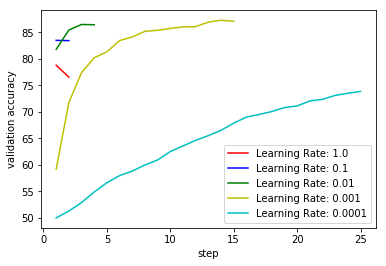

In [19]:
learning_rates = [(1.0, 'r'), (0.1, 'b'), (0.01, 'g'), (0.001, 'y'), (0.0001, 'c')]
for learning_rate, color in learning_rates:
    model = FastText(vocab_size, emb_dim)
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    validation_acc_history = []
    whole_steps = []
    whole_step = 0
    
    # Training the Model
    steps, validatino_acc_history = train(num_epochs, train_loader, validation_loader, model, whole_step, whole_steps)
    plt.plot(steps,validation_acc_history, color)

plt.ylabel('validation accuracy')
plt.xlabel('step')

red_line = mlines.Line2D([],[], color='r', label='Learning Rate: 1.0')
blue_line = mlines.Line2D([],[], color='b', label='Learning Rate: 0.1')
green_line = mlines.Line2D([],[], color='g', label='Learning Rate: 0.01')
yellow_line = mlines.Line2D([],[], color='y', label='Learning Rate: 0.001')
cyan_line = mlines.Line2D([],[], color='c', label='Learning Rate: 0.0001')

plt.legend(handles=[red_line, blue_line, green_line, yellow_line, cyan_line])
plt.show()

/Users/sangjunyum/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: [1/5], Step: [128/718], Loss: 0.6837365031242371, Train Acc: 56.26086956521739, Validation Acc:54.2
Epoch: [1/5], Step: [256/718], Loss: 0.6839431524276733, Train Acc: 61.58695652173913, Validation Acc:58.1
Epoch: [1/5], Step: [384/718], Loss: 0.6695722937583923, Train Acc: 66.49130434782609, Validation Acc:62.85
Epoch: [1/5], Step: [512/718], Loss: 0.6688225269317627, Train Acc: 70.61739130434782, Validation Acc:67.2
Epoch: [1/5], Step: [640/718], Loss: 0.6392481923103333, Train Acc: 73.57826086956521, Validation Acc:69.9


/Users/sangjunyum/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: [2/5], Step: [128/718], Loss: 0.5513551831245422, Train Acc: 77.78260869565217, Validation Acc:73.2
Epoch: [2/5], Step: [256/718], Loss: 0.6020321846008301, Train Acc: 79.87391304347825, Validation Acc:75.8
Epoch: [2/5], Step: [384/718], Loss: 0.5157215595245361, Train Acc: 81.35652173913043, Validation Acc:77.9
Epoch: [2/5], Step: [512/718], Loss: 0.48139098286628723, Train Acc: 82.38695652173914, Validation Acc:79.0
Epoch: [2/5], Step: [640/718], Loss: 0.507606565952301, Train Acc: 83.34347826086956, Validation Acc:80.1
Epoch: [3/5], Step: [128/718], Loss: 0.5063784122467041, Train Acc: 84.73913043478261, Validation Acc:81.15
Epoch: [3/5], Step: [256/718], Loss: 0.3301333785057068, Train Acc: 85.3913043478261, Validation Acc:82.05
Epoch: [3/5], Step: [384/718], Loss: 0.4610374867916107, Train Acc: 85.9304347826087, Validation Acc:82.8
Epoch: [3/5], Step: [512/718], Loss: 0.34326931834220886, Train Acc: 86.52173913043478, Validation Acc:83.55
Epoch: [3/5], Step: [640/718], Loss

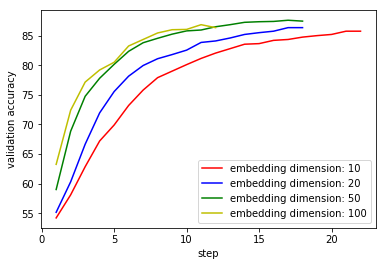

In [17]:
embedding_dims = [(10,'r'), (20,'b'), (50,'g'), (100,'y')]
learning_rate = 0.001
for emb_dim, color in embedding_dims:
    model = FastText(vocab_size, emb_dim)
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    validation_acc_history = []
    whole_steps = []
    whole_step = 0
    steps, validation_acc_history = train(num_epochs, train_loader, validation_loader, model, whole_step, whole_steps)
    plt.plot(steps,validation_acc_history, color)

plt.ylabel('validation accuracy')
plt.xlabel('step')

red_line = mlines.Line2D([],[], color='r', label='embedding dimension: 10')
blue_line = mlines.Line2D([],[], color='b', label='embedding dimension: 20')
green_line = mlines.Line2D([],[], color='g', label='embedding dimension: 50')
yellow_line = mlines.Line2D([],[], color='y', label='embedding dimension: 100')

plt.legend(handles=[red_line, blue_line, green_line, yellow_line])
plt.show()

/Users/sangjunyum/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: [1/5], Step: [128/718], Loss: 0.6686756610870361, Train Acc: 61.91304347826087, Validation Acc:60.4
Epoch: [1/5], Step: [256/718], Loss: 0.6343010663986206, Train Acc: 68.57391304347826, Validation Acc:66.6
Epoch: [1/5], Step: [384/718], Loss: 0.6201515197753906, Train Acc: 72.88260869565218, Validation Acc:70.95
Epoch: [1/5], Step: [512/718], Loss: 0.6009684801101685, Train Acc: 75.01304347826087, Validation Acc:73.6
Epoch: [1/5], Step: [640/718], Loss: 0.4711122214794159, Train Acc: 76.5304347826087, Validation Acc:74.45


/Users/sangjunyum/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: [2/5], Step: [128/718], Loss: 0.6031707525253296, Train Acc: 78.40869565217392, Validation Acc:77.7
Epoch: [2/5], Step: [256/718], Loss: 0.4092569053173065, Train Acc: 78.96521739130435, Validation Acc:78.4
Epoch: [2/5], Step: [384/718], Loss: 0.5104911923408508, Train Acc: 79.31739130434782, Validation Acc:79.25
Epoch: [2/5], Step: [512/718], Loss: 0.5971015691757202, Train Acc: 79.95217391304348, Validation Acc:80.25
Epoch: [2/5], Step: [640/718], Loss: 0.6857985854148865, Train Acc: 80.08695652173913, Validation Acc:80.65
Epoch: [3/5], Step: [128/718], Loss: 0.43263494968414307, Train Acc: 80.68260869565218, Validation Acc:81.2
Epoch: [3/5], Step: [256/718], Loss: 0.43716374039649963, Train Acc: 80.71304347826087, Validation Acc:81.15
earily stop triggered
Epoch: [1/5], Step: [128/718], Loss: 0.6817131042480469, Train Acc: 62.27391304347826, Validation Acc:60.1
Epoch: [1/5], Step: [256/718], Loss: 0.6445738673210144, Train Acc: 69.49130434782609, Validation Acc:68.45
Epoch: [

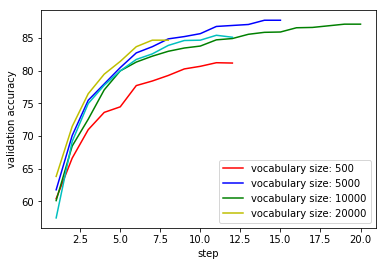

In [18]:
vocab_sizes = [(500,'r'), (5000,'g'), (10000,'b'), (20000,'y'), (30000,'c')]
learning_rate = 0.001
emb_dim = 50
for vocab_size, color in vocab_sizes:
    if(vocab_size < 20000):
        train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
        validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
        test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)
        
        # consturct datasets
        imdb_train = IMDBDataset(train_data)
        imdb_validation = IMDBDataset(validation_data)
        imdb_test = IMDBDataset(test_data)    
    
        # construct data loader
        train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
        validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                           batch_size=batch_size, 
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
        test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
        
    model = FastText(vocab_size, emb_dim)
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    validation_acc_history = []
    whole_steps = []
    whole_step = 0
    steps, validation_acc_history = train(num_epochs, train_loader, validation_loader, model, whole_step, whole_steps)
    plt.plot(steps,validation_acc_history, color)

plt.ylabel('validation accuracy')
plt.xlabel('step')

red_line = mlines.Line2D([],[], color='r', label='vocabulary size: 500')
blue_line = mlines.Line2D([],[], color='b', label='vocabulary size: 5000')
green_line = mlines.Line2D([],[], color='g', label='vocabulary size: 10000')
yellow_line = mlines.Line2D([],[], color='y', label='vocabulary size: 20000')
cyan_line = mlines.Line2D([],[], color='c', label='vocabulary size: 30000')

plt.legend(handles=[red_line, blue_line, green_line, yellow_line])
plt.show()
    

/Users/sangjunyum/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: [1/5], Step: [128/718], Loss: 0.6520073413848877, Train Acc: 51.0, Validation Acc:50.2
Epoch: [1/5], Step: [256/718], Loss: 0.6986433267593384, Train Acc: 54.995652173913044, Validation Acc:53.75
Epoch: [1/5], Step: [384/718], Loss: 0.6959318518638611, Train Acc: 60.52608695652174, Validation Acc:59.25
Epoch: [1/5], Step: [512/718], Loss: 0.6511222720146179, Train Acc: 64.54782608695652, Validation Acc:63.15
Epoch: [1/5], Step: [640/718], Loss: 0.6445696353912354, Train Acc: 66.74347826086957, Validation Acc:65.3


/Users/sangjunyum/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: [2/5], Step: [128/718], Loss: 0.6380035281181335, Train Acc: 69.87391304347825, Validation Acc:68.5
Epoch: [2/5], Step: [256/718], Loss: 0.5792608261108398, Train Acc: 71.4695652173913, Validation Acc:69.8
Epoch: [2/5], Step: [384/718], Loss: 0.5539913177490234, Train Acc: 72.92608695652174, Validation Acc:72.05
Epoch: [2/5], Step: [512/718], Loss: 0.5352022051811218, Train Acc: 74.2304347826087, Validation Acc:73.35
Epoch: [2/5], Step: [640/718], Loss: 0.5408240556716919, Train Acc: 75.25217391304348, Validation Acc:74.65
Epoch: [3/5], Step: [128/718], Loss: 0.3901377320289612, Train Acc: 76.40434782608696, Validation Acc:75.75
Epoch: [3/5], Step: [256/718], Loss: 0.49381229281425476, Train Acc: 77.00869565217391, Validation Acc:76.75
Epoch: [3/5], Step: [384/718], Loss: 0.4012504816055298, Train Acc: 77.50434782608696, Validation Acc:77.7
Epoch: [3/5], Step: [512/718], Loss: 0.5825942754745483, Train Acc: 77.99565217391304, Validation Acc:77.85
Epoch: [3/5], Step: [640/718], L

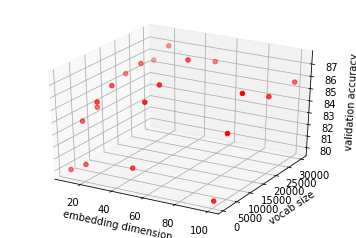

In [20]:
# Model Selection
optimal_validation_accuracy = 0
optimal_emb_dim = 0
optimal_vocab_size = 0

selected = object()
#train(num_epochs, train_loader, validation_loader, model, whole_step, whole_steps)
accuracy_results = [[],[],[]]


for emb_dim, _ in embedding_dims:
    for vocab_size, _ in vocab_sizes:
        if(vocab_size < 20000):
            train_data, train_ngram_indexer = process_text_dataset(train_set, ngram_n, vocab_size)
            validation_data, _ = process_text_dataset(validation_set, ngram_n, ngram_indexer=train_ngram_indexer)
            test_data, _ = process_text_dataset(test_set, ngram_n, ngram_indexer=train_ngram_indexer)
        
            # consturct datasets
            imdb_train = IMDBDataset(train_data)
            imdb_validation = IMDBDataset(validation_data)
            imdb_test = IMDBDataset(test_data)
    
            # construct data loader
            train_loader = torch.utils.data.DataLoader(dataset=imdb_train, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
            validation_loader = torch.utils.data.DataLoader(dataset=imdb_validation, 
                                           batch_size=batch_size, 
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
            test_loader = torch.utils.data.DataLoader(dataset=imdb_test, 
                                           batch_size=batch_size,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
        
        model = FastText(vocab_size, emb_dim)
        criterion = nn.BCELoss()  
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        validation_acc_history = []
        whole_steps = []
        whole_step = 0
        
        steps, validation_acc_history = train(num_epochs, train_loader,
                                              validation_loader, model, whole_step, whole_steps)
        #train(num_epochs, train_loader, validation_loader, model, whole_step, whole_steps)
        validation_acc = validation_acc_history[len(validation_acc_history) - 1]
        accuracy_results[0].append(emb_dim)
        accuracy_results[1].append(vocab_size)
        accuracy_results[2].append(validation_acc)
        
        if (validation_acc > optimal_validation_accuracy ):
            selected = model
            optimal_validation_accuracy = validation_acc
            optimal_emb_dim = emb_dim
            optimal_vocab_size = vocab_size
            
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(accuracy_results[0], accuracy_results[1], accuracy_results[2], c = 'r', depthshade=True)
ax.set_xlabel('embedding dimension')
ax.set_ylabel('vocab size')
ax.set_zlabel('validation accuracy')

plt.show()


Accuracy of the optimal model on the train set: 91 %
Accuracy of the optimal model on the test set: 86 %
Optimal validation accuracy is  87.5 %
Optimal embedding dimension is  50
Optimal vocabluary size is  20000


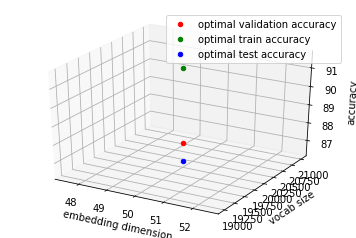

In [27]:
# Report the model
optimal_train_accuracy = test_model(train_loader, selected)
optimal_test_accuracy = test_model(test_loader, selected)
print('Accuracy of the optimal model on the train set: %d %%' % optimal_train_accuracy)
print('Accuracy of the optimal model on the test set: %d %%' % optimal_test_accuracy)
print('Optimal validation accuracy is ', optimal_validation_accuracy,'%')
print('Optimal embedding dimension is ', optimal_emb_dim)
print('Optimal vocabluary size is ', optimal_vocab_size)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([optimal_emb_dim], [optimal_vocab_size],[optimal_validation_accuracy], c = 'r', depthshade=True, label='optimal validation accuracy')
ax.scatter([optimal_emb_dim], [optimal_vocab_size],[optimal_train_accuracy], c = 'g', depthshade=True, label='optimal train accuracy')
ax.scatter([optimal_emb_dim], [optimal_vocab_size],[optimal_test_accuracy], c = 'b', depthshade=True, label='optimal test accuracy')

ax.set_xlabel('embedding dimension')
ax.set_ylabel('vocab size')
ax.set_zlabel('accuracy')

handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='upper right')
plt.show()


## Reference

Joulin, A., Grave, E., Bojanowski, P., & Mikolov, T. (2016). Bag of tricks for efficient text classification. arXiv preprint arXiv:1607.01759.